In [12]:
fname = "38_9686"
sigma = 5

%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

In [13]:
df = pd.read_csv("./input/clean_"+fname+".csv")
#df.drop(["meter_id"],axis=1,inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254547 entries, 0 to 254546
Data columns (total 3 columns):
meter_id     254547 non-null object
Timestamp    254547 non-null object
Values       254547 non-null float64
dtypes: float64(1), object(2)
memory usage: 5.8+ MB
None


<IPython.core.display.Javascript object>


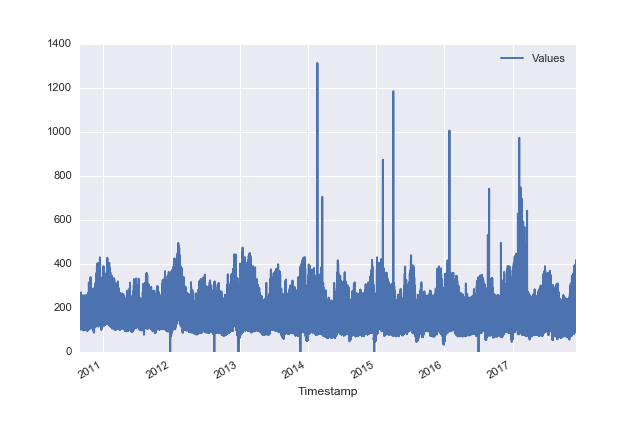

In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.plot(x='Timestamp', y='Values')

In [15]:
df['seconds'] = df['Timestamp'].dt.second
df['minutes'] = df['Timestamp'].dt.minute 
df['hours'] = df['Timestamp'].dt.hour
df['min'] = df['hours'].map(str)+":"+df['minutes'].map(str)
df['weeks'] = df['Timestamp'].dt.week
df['years'] = df['Timestamp'].dt.year
df['days'] = df['Timestamp'].dt.day
df['months'] = df['Timestamp'].dt.month
df['DayOfTheWeek'] = df['Timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 20)).astype(int)
df['time_epoch'] = (df['Timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [16]:
df["years"].value_counts()

2012    35135
2016    35118
2011    35040
2013    35039
2015    35033
2014    35025
2017    32438
2010    11719
Name: years, dtype: int64

In [17]:
df.head()

,meter_id,Timestamp,Values,seconds,minutes,hours,min,weeks,years,days,months,DayOfTheWeek,WeekDay,daylight,time_epoch
0,38_9686,2010-08-31 22:15:00,111.1250,0,15,22,22:15,35,2010,31,8,1,1,0,12832929
1,38_9686,2010-08-31 22:30:00,111.1250,0,30,22,22:30,35,2010,31,8,1,1,0,12832938
2,38_9686,2010-08-31 22:45:00,120.5625,0,45,22,22:45,35,2010,31,8,1,1,0,12832947
3,38_9686,2010-08-31 23:00:00,107.9375,0,0,23,23:0,35,2010,31,8,1,1,0,12832956
4,38_9686,2010-08-31 23:15:00,108.4375,0,15,23,23:15,35,2010,31,8,1,1,0,12832965


In [18]:
cols = ["months","WeekDay","hours"]
ds = df[(df["years"]!=2010)]
dm = dict(ds.groupby(by=cols)["Values"].mean())
dv = dict(ds.groupby(by=cols)["Values"].std())
dc = dict(ds.groupby(by=cols)["Values"].count())
df["key"] = list(zip(df[cols[0]], df[cols[1]], df[cols[2]]))

s = []
c = []
for x in dm:
    try:
        t = dm[x]/dv[x]
        s.append(t)
        c.append(dc[x])
    except:
        print(x,dm[x],dv[x],dm[x]/dv[x])
        
np.min(s),np.median(s),np.mean(s),np.max(s),np.median(c)

# (1.8345163448876793,
#  6.2133320489852295,
#  5.9926861726622755,
#  10.647108092613735,
#  396.0) ["months","WeekDay","hours"]

(1.8345163448876793,
 6.2133320489852295,
 5.9926861726622755,
 10.647108092613735,
 396.0)

In [19]:
from tqdm import tqdm
a = []
for key, value in zip(df.key, df.Values):
    try:
        a.append(int(abs(dm[key]-value)>sigma*dv[key]))
    except:
        a.append(0)
        #print(key)
df['anomaly21'] = a
print(sum(a),sum(a)/len(df))

198 0.0007778524201817346


<IPython.core.display.Javascript object>


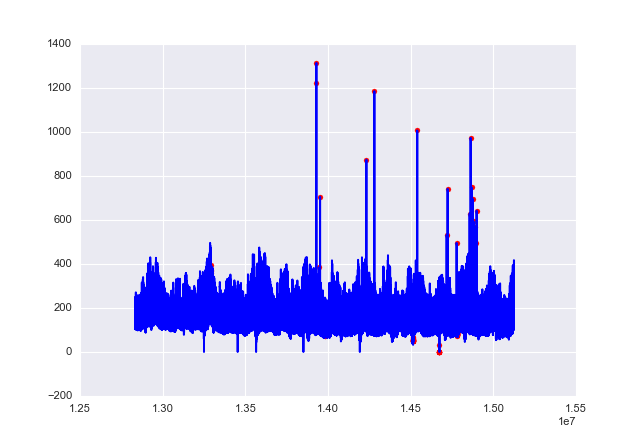

In [20]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'Values']] #anomaly

ax.plot(df['time_epoch'], df['Values'], color='blue')
ax.scatter(a['time_epoch'],a['Values'], color='red')
plt.show()

<IPython.core.display.Javascript object>


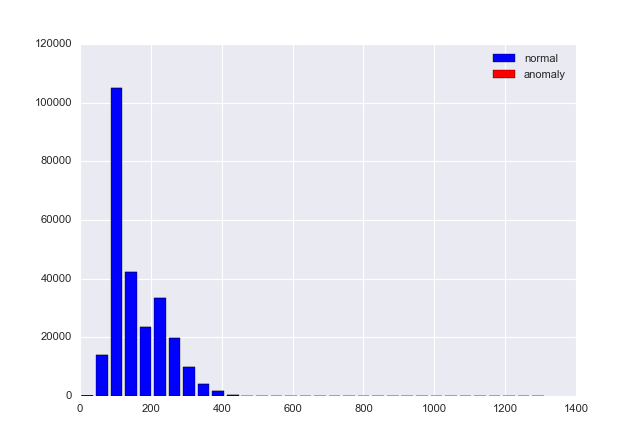

In [21]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'Values']
b = df.loc[df['anomaly21'] == 1, 'Values']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [22]:
df.to_csv("./output/"+fname+".csv", columns=["meter_id","Timestamp","anomaly21", "Values"], index=False)